In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Detecting Curvature from Flattening
> Both a validation, and a method unto itself!

**Hypothesis**: Stuff will happen

# Machinery

In [ ]:
import numpy as np
from geomstats.geometry.hypersphere import Hypersphere
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def polar_cap(n_samples=100, pole = [0., 0., 1.]):
    space = Hypersphere(dim=2)
    pole = np.array([pole])
    
    def is_in_cap(point, pole=pole):
        dot = np.dot(pole[0], point)
        return True if dot > 0 else False # Change this to >= for a thicker cap 

    points = [pole[0]]
    i = 0
    while len(points) < n_samples:
        i += 1
        candidate = space.random_uniform()
        if is_in_cap(candidate):
            points.append(candidate)
    
    return np.array(points)

In [ ]:
from scipy.spatial import cKDTree as KDTree
import networkx as nx
def compute_geodesic_length(pointA, pointB, space=Hypersphere(dim=2)):
    geodesic = space.metric.geodesic(initial_point=pointA, end_point=pointB)
    t = np.linspace(0, 1, 100)
    path = geodesic(t)
    
    lengths = []
    for i in range(len(path)-1):
        edge_length = space.metric.dist(path[i], path[i+1])
        lengths.append(edge_length)
        
    return np.sum(lengths)

def compute_euclidean_length(pointA, pointB):
    return np.linalg.norm(pointA-pointB)

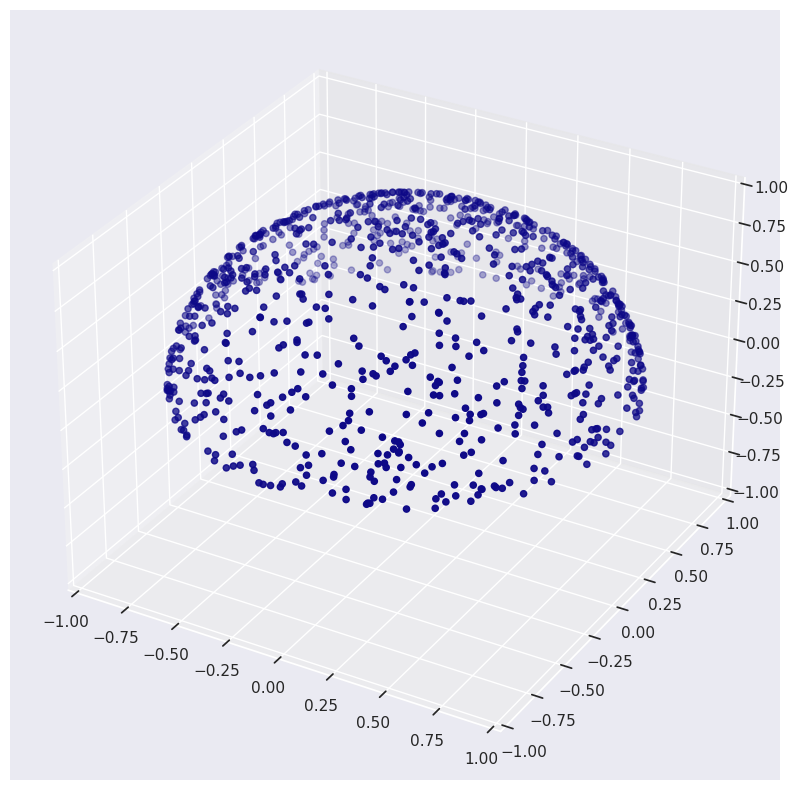

In [ ]:
# Generate a sample polar cap of the sphere and flatten it with AE
X_cap = polar_cap(n_samples=1000)
plot_3d(X_cap)

In [ ]:
def angular_distance(vec1, vec2):
    # Compute the dot product
    dot_product = np.dot(vec1, vec2)

    # Compute the magnitudes
    mag_vec1 = np.linalg.norm(vec1)
    mag_vec2 = np.linalg.norm(vec2)

    # Compute the cosine of the angle
    cos_theta = dot_product / (mag_vec1 * mag_vec2)

    # Compute the angle in radians
    theta = np.arccos(np.clip(cos_theta, -1, 1))

    # Convert the angle to distance on the unit sphere
    # The radius of the unit sphere is 1, so the distance is just the angle in radians
    return theta

# Assuming X_cap is an array of shape (N, 3), where N is the number of points,
# and each row is a point with (x, y, z) coordinates on the unit sphere
D_sphere = np.zeros((len(X_cap), len(X_cap)))
for i in range(len(X_cap)):
    vec1 = X_cap[i]
    for j in range(i+1, len(X_cap)):
        vec2 = X_cap[j]
        D_sphere[i, j] = angular_distance(vec1, vec2)
        D_sphere[j, i] = D_sphere[i, j]

In [ ]:
np.allclose(D_sphere[5,8],compute_geodesic_length(X_cap[5], X_cap[8]))

True

In [ ]:
from diffusion_curvature.radial_flattening_ae import radially_flatten_with_ae

In [ ]:
embedded_points = radially_flatten_with_ae(X_cap, D=None)

Using s_gd2 for MDS. None


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# scale the embedded_points to match the sphere distances
max_embedded = np.max(np.linalg.norm(embedded_points - embedded_points[0],axis=1))
max_sphere = np.max(D_sphere)
embedded_points = embedded_points * (max_sphere/max_embedded)

<matplotlib.collections.PathCollection>

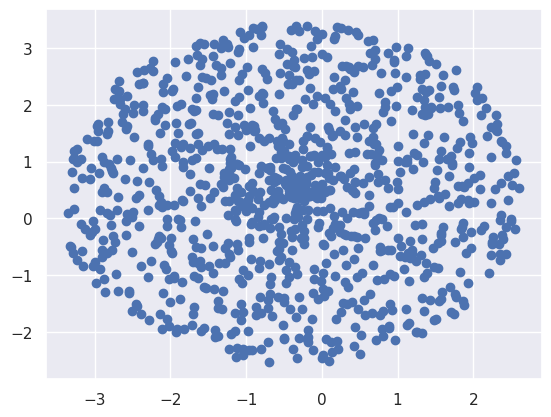

In [ ]:
plt.scatter(embedded_points[:,0], embedded_points[:,1])

In [ ]:
# from heatgeo.embedding import HeatGeo
# emb_op = HeatGeo(knn=5)
# emb = emb_op.fit_transform(X_cap)
# D_cap = emb_op.dist
# D_to_center = D_cap[0]

Using s_gd2 for MDS. None


Next we want to measure the curvature of this space by the degree to which triangles change in shape. In this case, all the triangles are centered at the origin -- so we're really just sampling pairs of points. We want a list of 50 pairs of point idxs such that:

1. The points have distances to center (found in the variable `D_to_center`) which are greater than 40% of points in the data.
2. Within each pair, the points have distances to each other greater than 15% of the rest of the data.

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

def generate_triangle_edges(X, D, num_triangles=50):
    # Compute percentiles for distances to center and between points
    D_center = D[0]
    center_percentile = np.percentile(D_center, 40) 
    pair_lower_percentile = np.percentile(D, 10) # 15% of points have distances greater than this
    pair_upper_percentile = np.percentile(D, 30) # 15% of points have distances greater than this
    print(pair_lower_percentile, pair_upper_percentile)

    # pair_percentile = np.percentile(D_cap,60) # 15% of points have distances greater than this

    # Get triangulation and indices to points that satisfy the conditions
    indices = []
    
    while len(indices) < num_triangles:
        idx1, idx2 = np.random.choice(len(X), size=2, replace=False)
        if D_center[idx1] > center_percentile and D_center[idx2] > center_percentile: # Condition 1
            if D[idx1, idx2] > pair_lower_percentile and D[idx1, idx2] < pair_upper_percentile: # Condition 2
                indices.append((idx1, idx2))
    return indices

# Results

In [ ]:
edges = generate_triangle_edges(X_cap, D_sphere)

0.47875340298243463 0.8957325479740158


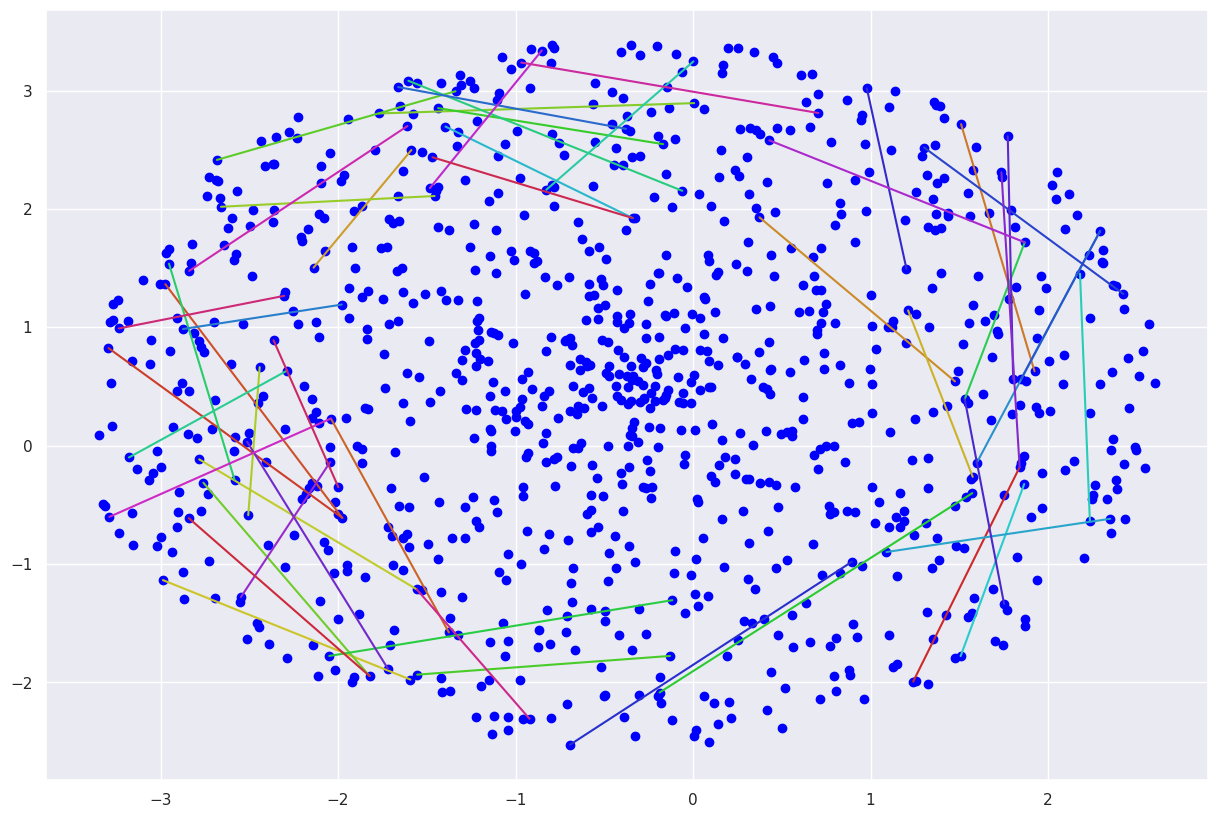

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import colorsys

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

for point in embedded_points:
    ax.scatter(*point, color="blue")
    
# Get indices and plot lines
num_edges = len(edges)
for i, (idx1, idx2) in enumerate(edges):
    pointA = embedded_points[idx1]
    pointB = embedded_points[idx2]
    
    # Compute color for this edge
    hue = i / num_edges
    rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.8)
    ax.plot([pointA[0], pointB[0]], [pointA[1], pointB[1]], color=rgb)


In [ ]:
total_geodesic = 0
total_euclidean = 0
for edge in edges:
    geodesic_dist = compute_geodesic_length(X_cap[edge[0]], X_cap[edge[1]])
    euclidean_dist = compute_euclidean_length(embedded_points[edge[0]], embedded_points[edge[1]])
    
    total_geodesic += geodesic_dist
    total_euclidean += euclidean_dist

print(f"Total geodesic length: {total_geodesic}")
print(f"Total euclidean length: {total_euclidean}")

Total geodesic length: 33.065871085061
Total euclidean length: 81.33543199300766


# Conclusion

In [ ]:
!pixi run zettelmaker

 WARN pixi::project::manifest: BETA feature `[pypi-dependencies]` enabled!

Please report any and all issues here:

	https://github.com/prefix-dev/pixi.

Turn this warning off by setting the environment variable `PIXI_BETA_WARNING_OFF` to `true`.

✨ Pixi task: quarto render nbs/experiments --to gfm --no-execute --output-dir ../zettels --profile zettels
Traceback (most recent call last):
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-d4ef08f07a26>", line 3, in <module>
ModuleNotFoundError: No module named 'diffusion_curvature'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/.pixi/env/bin/nbdev_filter", line 10, in <module>
    sys.exit(nbdev_filter